In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

from analysis import plot # imoporting analysis module enables import from model folder
import analysis.pipelines.population_spikes as ps

%matplotlib inline

RESULT_PATH = "simulation_results"
OUTPUT_PATH = "analysis_results"
overwrite = False

pop_color = plot.pop_color

In [2]:
ps.set_variables(RESULT_PATH=RESULT_PATH, OUTPUT_PATH=OUTPUT_PATH)

process_params = dict(
    fs_ct = 400.,  # Hz. spike count sampling frequency
    fs_fr = 50.,  # Hz. firing rate sampling frequency
    filt_sigma = 20.0  # ms. Gaussian filer sigma
)

In [3]:
# filter = (('short', 'long'), ('rand', 'div'))
filter = (('ramp', 'join', 'fade'), ('rand', 'div'))
trials = ps.get_trials(filter)
print(trials)

['fade_a01_t0.1_div', 'fade_a01_t0.1_rand', 'fade_a01_t0.3_div', 'fade_a01_t0.3_rand', 'fade_a01_t1.0_div', 'fade_a01_t1.0_rand', 'fade_a01_t3.0_div', 'fade_a01_t3.0_rand', 'fade_a03_t0.1_div', 'fade_a03_t0.3_div', 'fade_a03_t1.0_div', 'fade_a03_t3.0_div', 'join_a0_t0.3_div', 'join_a0_t0.3_rand', 'join_a0_t1.0_div', 'join_a0_t1.0_quit_div', 'join_a0_t1.0_quit_rand', 'join_a0_t1.0_rand', 'join_a0_t3.0_div', 'join_a0_t3.0_rand', 'ramp_a0_t0.3_div', 'ramp_a0_t0.3_rand', 'ramp_a0_t1.0_div', 'ramp_a0_t1.0_down_div', 'ramp_a0_t1.0_down_rand', 'ramp_a0_t1.0_rand', 'ramp_a0_t3.0_div', 'ramp_a0_t3.0_rand']


### Preprocess data

In [4]:
for trial in trials:
    ps.preprocess(trial, overwrite=overwrite, **process_params)

### Compute STP weights

In [5]:
# tau = 200.  # ms
tau = [40., 60., 100., 160., 250., 400.]  # ms
tau = np.asarray(tau).ravel() / 1000 # to sec

lag_range = [-40, 80]  # ms. range time lags

In [6]:
w_stp, fr_tot, lag_fr = zip(*[ps.get_stp_data(trial, tau, lag_range) for trial in trials])
trial_slice = np.cumsum([0] + list(map(len, fr_tot)))
trial_slice = dict(zip(trials, zip(trial_slice[:-1], trial_slice[1:])))

w_stp = np.concatenate(w_stp, axis=-1)
fr_tot = np.concatenate(fr_tot)
lag_fr = xr.concat(lag_fr, dim='time').stack(target=('population', 'lags'))

### Predict ITN firing rate with PN spike data

In [7]:
stp_fr_reg = [LinearRegression() for _ in range(tau.size)]
fr_pred = []
for i, reg in enumerate(stp_fr_reg):
    X = np.column_stack((w_stp[i], fr_tot))
    reg.fit(X, lag_fr.values)
    fr_pred.append(reg.predict(X))

In [8]:
root_mean_squared_error = lambda *arg, **kwargs: mean_squared_error(*arg, **kwargs) ** 0.5
error_metrics = {'R2 score': r2_score, 'RMSE': root_mean_squared_error}
pred_error = xr.DataArray([[m(lag_fr.values, y, multioutput='raw_values') \
    for m in error_metrics.values()] for y in fr_pred],
    coords=dict(tau=tau, metric=list(error_metrics), target=lag_fr.target)).unstack('target')

In [9]:
param_dims = {'tau': 'Time constant (ms)', 'lags': 'Time lags (ms)'}
optimal_idx = pred_error.sel(metric='RMSE').argmin(dim=list(param_dims))
optimal_param = xr.Dataset({d: pred_error.coords[d][optimal_idx[d]] for d in param_dims})

In [10]:
print("Optimal parameters:")
display(optimal_param.to_pandas())
print("Minimum error:")
min_error = pred_error.min(dim=param_dims)
display(min_error.to_pandas())

Optimal parameters:


,metric,tau,lags
population,,,
FSI,RMSE,0.25,0.0
LTS,RMSE,0.10,0.0


Minimum error:


population,FSI,LTS
metric,,
R2 score,0.380952,0.837840
RMSE,2.028261,1.560006


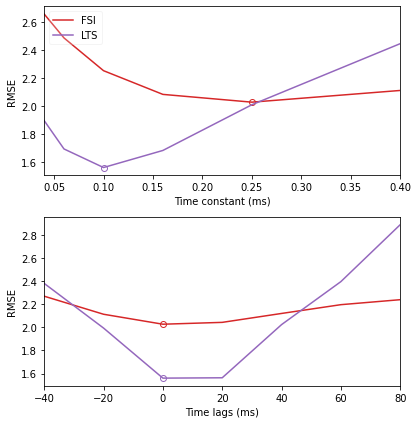

In [11]:
error = pred_error.sel(metric='RMSE')

_, axs = plt.subplots(len(param_dims), 1, figsize=(6, 6))
for ax, (pdm, label) in zip(axs, param_dims.items()):
    for p in error.population.values:
        opt_p = optimal_param.sel(population=p)
        err = error.sel(population=p, **{d: opt_p[d] for d in param_dims if d != pdm})
        ax.plot(error[pdm], err, color=pop_color[p], label=p)
        ax.plot(opt_p[pdm], err.sel(**{pdm: opt_p[pdm]}),
                color=pop_color[p], marker='o', markerfacecolor='none')
    ax.set_xlim(error[pdm][[0, -1]])
    ax.set_xlabel(label)
    ax.set_ylabel(error.metric.item())
axs[0].legend(loc='upper left', framealpha=0.2)
plt.tight_layout()
plt.show()

In [12]:
linestyle = {'actual': '-', 'predict': '--'}
opt_pred = []
for p in optimal_param.population.values:
    opt_p = optimal_param.sel(population=p)
    trg = (p, opt_p.lags.item())
    opt_lag_fr = lag_fr.sel(target=trg).values
    trg_idx = lag_fr.target.to_index().get_loc(trg)
    tau_idx = pred_error.tau.to_index().get_loc(opt_p.tau.item())
    opt_fr_pred = fr_pred[tau_idx][:, trg_idx]
    opt_pred.append([opt_lag_fr, opt_fr_pred])
opt_pred = xr.DataArray(opt_pred, coords=dict(
    population=optimal_param.population, output=list(linestyle), time=lag_fr.time))

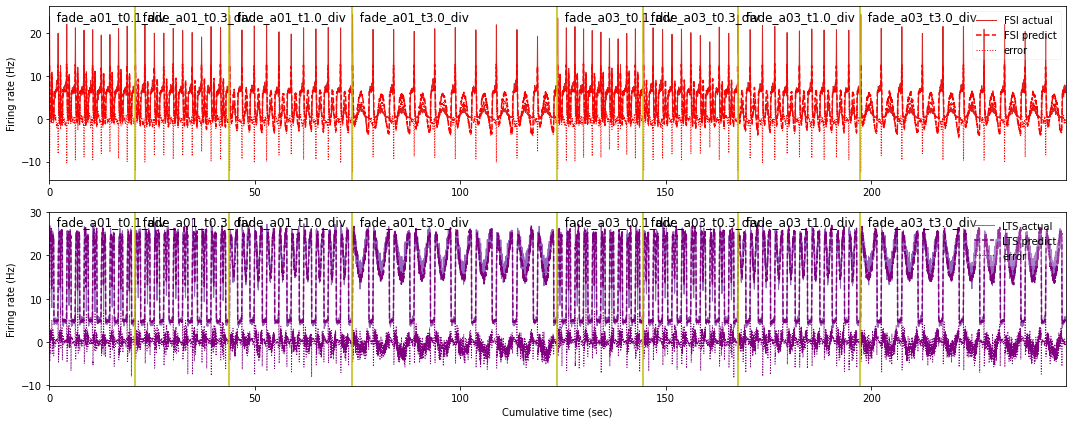

In [23]:
from matplotlib.transforms import blended_transform_factory

# trial_filt = ['']  # show all trials
trial_filt = ['fade', 'div']  # conditions for filtering trials
show_slice = {tr: trial_slice[tr] for tr in ps.get_trials(trial_filt, trial_list=trials)}

_, axs = plt.subplots(opt_pred.population.size, 1, figsize=(15, 3 * opt_pred.population.size))
T = 0
for i, (trial, idx) in enumerate(show_slice.items()):
    idx = slice(*idx)
    t = T + opt_pred.time[idx] / 1000
    T = t[-1]
    for p, ax in zip(opt_pred.population.values, axs):
        Y = opt_pred.isel(time=idx).sel(population=p)
        for y in opt_pred.output.values:
            clr = pop_color[p].replace('tab:', '') if y == 'predict' else pop_color[p]
            linewidth = 1.5 if y == 'predict' else 1
            label = None if i else f'{p} {y}'
            ax.plot(t, Y.sel(output=y), color=clr, linewidth=linewidth,
                    linestyle=linestyle[y], label=label)
        ax.plot(t, Y.sel(output='predict') - Y.sel(output='actual'), color=clr,
                linewidth=1, linestyle=':', label=None if i else 'error')
        if i:
            ax.axvline(x=t[0], color='y')
        trans = blended_transform_factory(ax.transData, ax.transAxes)
        ax.text(t[0], 0.98, '  ' + trial, transform=trans, fontsize='large',
                horizontalalignment='left', verticalalignment='top')
for ax in axs:
    ax.set_xlim([0, T])
    ax.set_ylabel('Firing rate (Hz)')
    ax.legend(loc='upper right', framealpha=0.2)
axs[-1].set_xlabel('Cumulative time (sec)')
plt.tight_layout()
plt.show()